# __Movie Sentiment Analysis__

In [245]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils
import spacy
import spacy_transformers

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from flashtext import KeywordProcessor
from textblob import TextBlob


warnings.filterwarnings("ignore")

## Importing Dataset for Movie Metadata

Use the IMDB dataset containing information about movies. Two different data sources will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/

In [246]:
# Open file containing movie metadata
movies_metadata_df = pd.read_csv("./dataset/movies_metadata.csv")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [247]:
# Open file containing the movie credits, i.e. casts and crews
movies_credits_df = pd.read_csv("./dataset/credits.csv")
movies_credits_df.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [248]:
# Combine the dataframes of movie metadata and credits
movies_metadata_df = pd.merge(movies_metadata_df, movies_credits_df, on=["id"], how="left")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [249]:
# List all the columns in movie metadata's dataframe
movies_metadata_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [250]:
# Drop columns that are not relevant
del_columns = ['belongs_to_collection', 'homepage', 'id', 'original_language', 'original_title', 'popularity', 'poster_path', 'adult',
               'overview', 'tagline', 'production_countries', 'spoken_languages', 'status', 'video', 'vote_average', 'vote_count']
movies_metadata_df = movies_metadata_df.drop(del_columns, axis=1)

# Remove 'tt' appended on the IMDB ID
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].apply(lambda x : x[2:] if isinstance(x, str) and "tt" in x else x)

movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0113228,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",12/22/1995,0.0,101.0,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0114885,[{'name': 'Twentieth Century Fox Film Corporat...,12/22/1995,81452156.0,127.0,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,0,"[{'id': 35, 'name': 'Comedy'}]",0113041,"[{'name': 'Sandollar Productions', 'id': 5842}...",2/10/1995,76578911.0,106.0,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


__b. Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [251]:
# Open another file containing the movie metadata
movies_df = pd.read_csv("./dataset/movies.csv")
movies_df.head(5)

,imdbId,Imdb Link,Title,IMDB Score,Genre,local_image_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation;Adventure;Comedy,images/114709_.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action;Adventure;Family,images/113497_.jpg
2,113277,http://www.imdb.com/title/tt113277,Heat (1995),8.2,Action;Crime;Drama,images/113277_.jpg
3,114319,http://www.imdb.com/title/tt114319,Sabrina (1995),6.3,Comedy;Drama,images/114319_.jpg
4,114576,http://www.imdb.com/title/tt114576,Sudden Death (1995),5.7,Action;Crime;Thriller,images/114576_.jpg


In [252]:
# Rename the column names of movies info by removing the spaces and converting to lower case
movies_df = movies_df.rename(columns={"imdbId" : "imdb_id", "Imdb Link" : "imbd_link", "Title" : "movie", "IMDB Score" : "imdb_score", "Genre" : "genre"})
print(movies_df.columns)

Index(['imdb_id', 'imbd_link', 'movie', 'imdb_score', 'genre',
       'local_image_path'],
      dtype='object')


In [253]:
# Drop columns that are not relevant
del_columns = ['imbd_link', 'imdb_score', 'local_image_path']

movies_df = movies_df.drop(columns=del_columns, axis=1)
movies_df.head(5)

,imdb_id,movie,genre
0,114709,Toy Story (1995),Animation;Adventure;Comedy
1,113497,Jumanji (1995),Action;Adventure;Family
2,113277,Heat (1995),Action;Crime;Drama
3,114319,Sabrina (1995),Comedy;Drama
4,114576,Sudden Death (1995),Action;Crime;Thriller


In [254]:
# Merge two different datasets for movies metadata

movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].fillna(0) # fixed errors on NaN values when converting to int data type
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].astype(int)

movies_metadata_df = pd.merge(movies_metadata_df, movies_df, on=["imdb_id"], how="right")
movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew,movie,genre
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",Toy Story (1995),Animation;Adventure;Comedy
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Jumanji (1995),Action;Adventure;Family
2,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",113277,"[{'name': 'Regency Enterprises', 'id': 508}, {...",12/15/1995,187436818.0,170.0,Heat,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",Heat (1995),Action;Crime;Drama
3,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",114319,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",12/15/1995,0.0,127.0,Sabrina,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",Sabrina (1995),Comedy;Drama
4,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",114576,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",12/22/1995,64350171.0,106.0,Sudden Death,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",Sudden Death (1995),Action;Crime;Thriller


## Importing Dataset for Movie Reviews

Use the IMDB dataset for movie reviews.

__Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [255]:
# Open the file containing the movie reviews
reviews_df = pd.read_csv("./dataset/reviews.csv")
reviews_df.head(5)

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw1133942,OriginalMovieBuff21,Kill Bill: Vol. 2 (2004),8.0,Good follow up that answers all the questions,24 July 2005,0,"After seeing Tarantino's Kill Bill Vol: 1, I g...","['0', '1']"
1,rw1133959,lost-in-limbo,Feardotcom (2002),3.0,"""I couldn't make much sense of it myself"". Too...",24 July 2005,0,There's a Website called FearDotCom and anyone...,"['1', '4']"
2,rw1133985,NateManD,Persona (1966),10.0,Persona gives me all the reasons to love art-h...,24 July 2005,0,"Long before ""Muholland Drive"" there was anothe...","['9', '23']"
3,rw1133999,CAMACHO-4,War of the Worlds (2005),3.0,A disappointing film from the team that you Mi...,24 July 2005,0,Spielberg said this film is based on the H.G. ...,"['9', '14']"
4,rw1134010,CAMACHO-4,Mr. & Mrs. Smith (2005),6.0,A fun action movie with great chemistry,24 July 2005,0,"Director Doug Liman, who's gotten famous for m...","['1', '3']"


In [256]:
# Merge the movie metadata (from the same kaggle source) and reviews
movie_reviews_df = pd.merge(movies_df, reviews_df, on=["movie"], how="inner")
movie_reviews_df.head(5)

,imdb_id,movie,genre,review_id,reviewer,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,112896,Dracula: Dead and Loving It (1995),Comedy;Fantasy;Horror,rw1134355,dunmore_ego,2.0,Frightfully Fangless,22 July 2005,0,"When a ""serious"" movie is pitifully appalling,...","['8', '18']"
1,113862,Mr. Holland's Opus (1995),Drama;Music,rw1133201,movieratings03,NaN,"Original, Insightful, And Thoroughly Entertaining",23 July 2005,0,MR. HOLLAND'S OPUS **** Director Stephen Herek...,"['2', '4']"
2,113972,Nick of Time (1995),Action;Crime;Drama,rw1134777,monkey-man,6.0,really good movie,25 July 2005,1,I only hired this movie because Johnny Depp an...,"['2', '4']"
3,114898,Waterworld (1995),Action;Adventure;Sci-Fi,rw1134904,bob the moo,NaN,"Despite the undeserved kicking, this is still ...",25 July 2005,0,"The polar icecaps have melted, all land has be...","['3', '8']"
4,114214,The Quick and the Dead (1995),Action;Romance;Thriller,rw1134345,SeminolePhenom,6.0,Modern Western with good idea,25 July 2005,0,The movie is about a quick-draw contest in a s...,"['4', '10']"


In [257]:
# Drop columns that are not relevant, including the movie and genre. IMDB ID can be used to associate 
# review records with movie metadata
# del_columns = ['movie', 'genre', 'review_id', 'reviewer', 'spoiler_tag', 'helpful', 'rating']
del_columns = ['movie', 'genre', 'review_id', 'reviewer', 'spoiler_tag', 'helpful']

movie_reviews_df = movie_reviews_df.drop(columns=del_columns, axis=1)
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_date,review_detail
0,112896,2.0,Frightfully Fangless,22 July 2005,"When a ""serious"" movie is pitifully appalling,..."
1,113862,NaN,"Original, Insightful, And Thoroughly Entertaining",23 July 2005,MR. HOLLAND'S OPUS **** Director Stephen Herek...
2,113972,6.0,really good movie,25 July 2005,I only hired this movie because Johnny Depp an...
3,114898,NaN,"Despite the undeserved kicking, this is still ...",25 July 2005,"The polar icecaps have melted, all land has be..."
4,114214,6.0,Modern Western with good idea,25 July 2005,The movie is about a quick-draw contest in a s...


## Exploratory Data Analysis

Check and resolve duplicate records

In [258]:
# Drop duplicate records in movies metadata
print(f"Record count before removing duplicates => {movies_metadata_df.shape[0]}")
movies_metadata_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movies_metadata_df.shape[0]}")

Record count before removing duplicates => 4174
Record count after removing duplicates  => 4071


In [259]:
# Drop duplicate records in movies reviews
print(f"Record count before removing duplicates => {movie_reviews_df.shape[0]}")
movie_reviews_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movie_reviews_df.shape[0]}")

Record count before removing duplicates => 208
Record count after removing duplicates  => 208


Tally the number of reviews categorized by customer ratings ranging from 1 (lowest) to 10 (highest) to gauge the overall sentiment of the dataset based on these ratings.

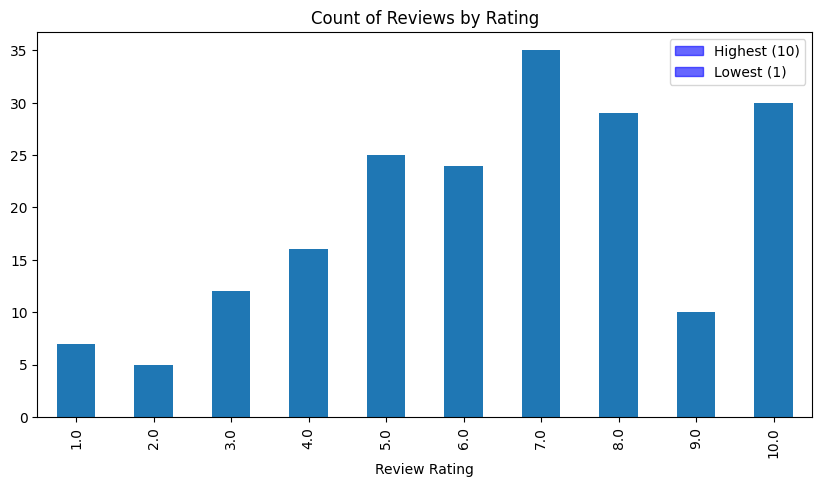

In [260]:
import matplotlib.pyplot as plt

# Count the reviews based on customer ratings
ax = movie_reviews_df['rating'].value_counts().sort_index() \
    .plot(kind='bar', title='Count of Reviews by Rating', figsize=(10, 5))

ax.set_xlabel('Review Rating')

# Add a custom legend indicating 10 as highest and 1 as lowest
legend_labels = {10: 'Highest (10)', 1: 'Lowest (1)'}
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.6, label=label)
                  for rating, label in legend_labels.items()]

ax.legend(handles=legend_handles, labels=legend_labels.values(), loc='upper right')

plt.show()




Check and resolve missing values for `movie metadata`

In [261]:
# Check for missing values in movies metadata
movies_metadata_df.isna().sum()

budget                  3
genres                  3
imdb_id                 0
production_companies    3
release_date            3
revenue                 3
runtime                 3
title                   3
cast                    3
crew                    3
movie                   0
genre                   0
dtype: int64

In [262]:
# List of movies with missing information
movies_metadata_df[movies_metadata_df['title'].isna()]

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew,movie,genre
2780,NaN,NaN,462322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grindhouse (2007),Action;Horror;Thriller
3521,NaN,NaN,448694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puss in Boots (2011),Animation;Action;Adventure
3793,NaN,NaN,1937390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nymphomaniac: Vol. I (2013),Drama


In [263]:
# Drop all movies with missing information
movies_metadata_df.dropna(inplace=True, axis=0)
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4068 entries, 0 to 4173
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4068 non-null   float64
 1   genres                4068 non-null   object 
 2   imdb_id               4068 non-null   int64  
 3   production_companies  4068 non-null   object 
 4   release_date          4068 non-null   object 
 5   revenue               4068 non-null   float64
 6   runtime               4068 non-null   float64
 7   title                 4068 non-null   object 
 8   cast                  4068 non-null   object 
 9   crew                  4068 non-null   object 
 10  movie                 4068 non-null   object 
 11  genre                 4068 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 413.2+ KB


Check and resolve missing values for `movie reviews`

In [264]:
# Check for missing values in movies reviews
movie_reviews_df.isna().sum()

imdb_id            0
rating            15
review_summary     0
review_date        0
review_detail      0
dtype: int64

In [265]:
# Replace all missing values in review summary and detail with a blank
movie_reviews_df[['review_summary', 'review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].fillna('')
movie_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   imdb_id         208 non-null    int64  
 1   rating          193 non-null    float64
 2   review_summary  208 non-null    object 
 3   review_date     208 non-null    object 
 4   review_detail   208 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.2+ KB


#### __Data Wrangling and Visualizations__:

Conduct data wrangling on `movie metadata` to transform and structure data into a desired format

In [266]:
# Separate movie release year from the title
pattern_year = r'\((\d{4})\)$'
movies_metadata_df['release_year'] = movies_metadata_df['movie'].str.extract(pattern_year).astype(int)
movies_metadata_df['movie'] = movies_metadata_df['movie'].str.replace(pattern_year, '', regex=True).str.strip()
movies_metadata_df[['movie', 'release_year']].head(5)

# Drop columns containing duplicate movie information
dup_columns = ['genres', 'release_date', 'title']
movies_metadata_df = movies_metadata_df.drop(columns=dup_columns, axis=1)

# Rearrange the order of columns
desired_order = ['imdb_id', 'movie', 'release_year', 'genre', 'runtime', 'budget', 'revenue', 'production_companies', 'cast', 'crew']
movies_metadata_df = movies_metadata_df[desired_order]

movies_metadata_df.head(5)

,imdb_id,movie,release_year,genre,runtime,budget,revenue,production_companies,cast,crew
0,114709,Toy Story,1995,Animation;Adventure;Comedy,81.0,30000000.0,373554033.0,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,113497,Jumanji,1995,Action;Adventure;Family,104.0,65000000.0,262797249.0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,113277,Heat,1995,Action;Crime;Drama,170.0,60000000.0,187436818.0,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,114319,Sabrina,1995,Comedy;Drama,127.0,58000000.0,0.0,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,114576,Sudden Death,1995,Action;Crime;Thriller,106.0,35000000.0,64350171.0,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


In [267]:
# Convert genre into list data type
movies_metadata_df['genre'] = movies_metadata_df['genre'].apply(lambda x : x.split(";"))

# Convert to a list of production companies
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda x : utils.convert_str_to_dict(x, ['name']))
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda list_of_dicts : [value for d in list_of_dicts for value in d.values()])

# TODO: Need to fix the issue on cast and crew with names containing single quotation
# movies_metadata_df['cast'] = movies_metadata_df['cast'].apply(lambda x : utils.convert_str_to_dict(x, ['character', 'name']))

movies_metadata_df[['genre', 'production_companies', 'cast', 'crew']].head(5)

,genre,production_companies,cast,crew
0,"[Animation, Adventure, Comedy]",[Pixar Animation Studios],"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,"[Action, Adventure, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,"[Action, Crime, Drama]","[Regency Enterprises, Forward Pass, Warner Bros.]","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,"[Comedy, Drama]","[Paramount Pictures, Scott Rudin Productions, ...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,"[Action, Crime, Thriller]","[Universal Pictures, Imperial Entertainment, S...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


Conduct data wrangling on `movie review` to transform and structure data into a desired format

In [268]:
# Get only the year the review was created
movie_reviews_df['review_year'] = pd.to_datetime(movie_reviews_df['review_date']).dt.year
movie_reviews_df = movie_reviews_df.drop(columns=['review_date'], axis=1)

movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_detail,review_year
0,112896,2.0,Frightfully Fangless,"When a ""serious"" movie is pitifully appalling,...",2005
1,113862,NaN,"Original, Insightful, And Thoroughly Entertaining",MR. HOLLAND'S OPUS **** Director Stephen Herek...,2005
2,113972,6.0,really good movie,I only hired this movie because Johnny Depp an...,2005
3,114898,NaN,"Despite the undeserved kicking, this is still ...","The polar icecaps have melted, all land has be...",2005
4,114214,6.0,Modern Western with good idea,The movie is about a quick-draw contest in a s...,2005


Perform additional analysis of the data and create visual representations to gain a better understanding of the movie metadata and reviews. This information provides insights on trends and patterns in the movie data, which might be important especially on the reports that will be provided to the client.

In [269]:
# Show statistical summary of movie metadata and reviews
pd.merge(movies_metadata_df, movie_reviews_df, on=["imdb_id"], how="inner").describe()

,imdb_id,release_year,runtime,budget,revenue,rating,review_year
count,208.000000,208.000000,208.000000,2.080000e+02,2.080000e+02,193.000000,208.0
mean,235534.254808,1993.600962,109.860577,3.920896e+07,1.113068e+08,6.492228,2005.0
std,140355.716287,18.220056,19.959495,4.819557e+07,1.734003e+08,2.421946,0.0
min,13442.000000,1922.000000,64.000000,0.000000e+00,0.000000e+00,1.000000,2005.0
25%,109157.250000,1993.500000,98.000000,0.000000e+00,0.000000e+00,5.000000,2005.0
50%,244358.500000,2001.000000,107.000000,1.500000e+07,2.830972e+07,7.000000,2005.0
75%,370149.750000,2005.000000,120.250000,6.700000e+07,1.503193e+08,8.000000,2005.0
max,449040.000000,2005.000000,189.000000,1.750000e+08,8.500000e+08,10.000000,2005.0


In [270]:
# TODO: Insert more visualizations

#### __For Text Pre-processing__:

__The movie summary and reviews undergo the following steps during the initial data pre-processing stage__
- Remove non-grammatical text like emails and URLs
- Replace non-ascii characters (some Python libraries are only limited to ascii characters like KeywordProcessor)
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [271]:
emoji_dict = tp.get_emojis()
slang_word_dict = tp.get_slang_words(webscraped=False)

def initial_text_preprocessing(text):
    try:
        # Remove non-grammatical text
        text = tp.remove_email_address(text)
        text = tp.remove_hyperlink(text)

        # Replace non-ascii characters as there are Python libraries limiting this feature
        text = tp.replace_nonascii_characters(text)

        # Replace emojis with English word/s
        text = emoji_dict.replace_keywords(text)

        # Handle contractions
        text = contractions.fix(text)

        # Replace slang words
        text = slang_word_dict.replace_keywords(text)

    except Exception as err:
        print(f"ERROR: {err}")
        print(f"Input Text: {text}")

    return text


movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].applymap(initial_text_preprocessing)

# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nCleaned Review Summary:")
    print(movie_reviews_df['cleaned_review_summary'][i])
    print("="*100)

# Display the comparison between the top 5 original review details and their cleaned versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nCleaned Review Details:")
    print(movie_reviews_df['cleaned_review_detail'][i])
    print("="*100)

Original Review Summary:
Frightfully Fangless

Cleaned Review Summary:
Frightfully Fangless
Original Review Summary:
Original, Insightful, And Thoroughly Entertaining

Cleaned Review Summary:
Original, Insightful, And Thoroughly Entertaining
Original Review Summary:
really good movie

Cleaned Review Summary:
really good movie
Original Review Summary:
Despite the undeserved kicking, this is still an enjoyable summer blockbuster, nothing more but certainly nothing less

Cleaned Review Summary:
Despite the undeserved kicking, this is still an enjoyable summer blockbuster, nothing more but certainly nothing less
Original Review Summary:
Modern Western with good idea

Cleaned Review Summary:
Modern Western with good idea
Original Review Details:
When a "serious" movie is pitifully appalling, it is easy to write a comedic review. When a comedic movie falls into the same category, it is almost impossible to make sport of it  because any frivolity in the review may be misconstrued as comedic 

__Name Entity Recognition (NER)__

In [272]:
# # TODO: Train own NER with the names of crews and casts and other important info

# # Load the English language model in spaCy
# nlp = spacy.load("en_core_web_sm")

# # Create a new dataFrame to store extracted name entitiesm then combine/rename the following labels
# # - LOCATION : GPE, LOC and FACE
# # - DATE_TIME : DATE, TIME
# # - ORGANIZATION : ORG

# column_names = ['PERSON', 'WORK_OF_ART', 'LOCATION', 'DATE_TIME', 'ORGANIZATION', 'PRODUCT', 'EVENT', 'LANGUAGE']
# movie_name_entities_df = pd.DataFrame(columns=column_names)

# # Extract and remove name entities from 'cleaned_review_summary' and 'cleaned_review_detail' columns
# movie_reviews_df['cleaned_review_summary'], movie_name_entities_df = tp.extract_name_entity(movie_reviews_df['cleaned_review_summary'], nlp, movie_name_entities_df)
# movie_reviews_df['cleaned_review_detail'], movie_name_entities_df = tp.extract_name_entity(movie_reviews_df['cleaned_review_detail'], nlp, movie_name_entities_df)

# # Display the comparison between the top 5 original review summaries and their cleaned versions
# for i in range(5):
#     print("Original Review Summary:")
#     print(movie_reviews_df['review_summary'][i])
#     print("\nCleaned Review Summary (NER Removed):")
#     print(movie_reviews_df['cleaned_review_summary'][i])
#     print("="*50)

# # Display the comparison between the top 5 original review details and their cleaned versions
# for i in range(5):
#     print("Original Review Details:")
#     print(movie_reviews_df['review_detail'][i])
#     print("\nCleaned Review Details (NER Removed):")
#     print(movie_reviews_df['cleaned_review_detail'][i])
#     print("="*50)

In [273]:
# # Dataframe of the extracted name entities
# movie_name_entities_df = pd.merge(movie_reviews_df['imdb_id'], movie_name_entities_df, left_index=True, right_index=True)
# movie_name_entities_df.head(10)

__Utilize regular expressions to eliminate punctuation, substitute whitespaces, transform characters to lowercase, and filter out stopwords from movie reviews__

In [274]:
# Initialize the English stop words list
list_of_stopwords = set(stopwords.words('english'))

def supplemental_text_preprocessing(text):
    # Remove non-alphanumeric characters except for the following
    # - hyphen (-) that is in between alphanumeric
    text = tp.remove_non_alphanumeric_char(text)
    
    # Remove leading and trailing whitespaces
    text = text.strip()

    # Replace multiple whitespaces with a single space
    text = tp.replace_whitespace(text)

    # Remove stopwords
    text = tp.remove_stopwords(text, list_of_stopwords)

    return text

# Apply text cleaning to 'cleaned_review_summary' and 'cleaned_review_detail' columns
movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']]\
                                                                            .applymap(supplemental_text_preprocessing)

# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nCleaned Review Summary (Non-alphanumeric Characters Removed, Lowercased, Extra Whitespaces Removed, Stopwords Removed):")
    print(movie_reviews_df['cleaned_review_summary'][i])
    print("="*100)

# Display the comparison between the top 5 original review details and their cleaned versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nCleaned Review Details (Non-alphanumeric Characters Removed, Lowercased, Extra Whitespaces Removed, Stopwords Removed):")
    print(movie_reviews_df['cleaned_review_detail'][i])
    print("="*100)

Original Review Summary:
Frightfully Fangless

Cleaned Review Summary (Non-alphanumeric Characters Removed, Lowercased, Extra Whitespaces Removed, Stopwords Removed):
Frightfully Fangless
Original Review Summary:
Original, Insightful, And Thoroughly Entertaining

Cleaned Review Summary (Non-alphanumeric Characters Removed, Lowercased, Extra Whitespaces Removed, Stopwords Removed):
Original Insightful And Thoroughly Entertaining
Original Review Summary:
really good movie

Cleaned Review Summary (Non-alphanumeric Characters Removed, Lowercased, Extra Whitespaces Removed, Stopwords Removed):
really good movie
Original Review Summary:
Despite the undeserved kicking, this is still an enjoyable summer blockbuster, nothing more but certainly nothing less

Cleaned Review Summary (Non-alphanumeric Characters Removed, Lowercased, Extra Whitespaces Removed, Stopwords Removed):
Despite undeserved kicking still enjoyable summer blockbuster nothing certainly nothing less
Original Review Summary:
Mod

__Implement Spacy's lemmatization on movie reviews, emphasizing the significance of lemmatization in capturing the base or root form of words__

In [275]:
# TODO: Words with hyphen are being tokenized or split

# Load the spaCy language model
# See: https://spacy.io/usage/models
nlp = spacy.load("en_core_web_sm")
    
# Apply lemmatization to 'review_summary' and 'review_detail' columns
movie_reviews_df['cleaned_review_summary'] = tp.lemmatize_text(movie_reviews_df['cleaned_review_summary'], nlp)
movie_reviews_df['cleaned_review_detail'] = tp.lemmatize_text(movie_reviews_df['cleaned_review_detail'], nlp)

# Display the comparison between the top 5 original review summaries and their lemmatized versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nLemmatized Review Summary:")
    print(movie_reviews_df['cleaned_review_summary'][i])
    print("="*100)

# Display the comparison between the top 5 original review details and their lemmatized versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nLemmatized Review Details:")
    print(movie_reviews_df['cleaned_review_detail'][i])
    print("="*100)

Original Review Summary:
Frightfully Fangless

Lemmatized Review Summary:
Frightfully Fangless
Original Review Summary:
Original, Insightful, And Thoroughly Entertaining

Lemmatized Review Summary:
original Insightful thoroughly entertain
Original Review Summary:
really good movie

Lemmatized Review Summary:
good movie
Original Review Summary:
Despite the undeserved kicking, this is still an enjoyable summer blockbuster, nothing more but certainly nothing less

Lemmatized Review Summary:
despite undeserved kicking enjoyable summer blockbuster certainly
Original Review Summary:
Modern Western with good idea

Lemmatized Review Summary:
modern western good idea
Original Review Details:
When a "serious" movie is pitifully appalling, it is easy to write a comedic review. When a comedic movie falls into the same category, it is almost impossible to make sport of it  because any frivolity in the review may be misconstrued as comedic quality that the MOVIE possesses. So let me clarify from th

In [276]:
# Open file containing movie metadata
#movie_reviews_df = pd.read_csv("./dataset/movie_reviews_df.csv")
#movie_reviews_df.head(5)

__Visualization using WordCloud to understand the most frequent words present in the cleaned data on movie_reviews_df__

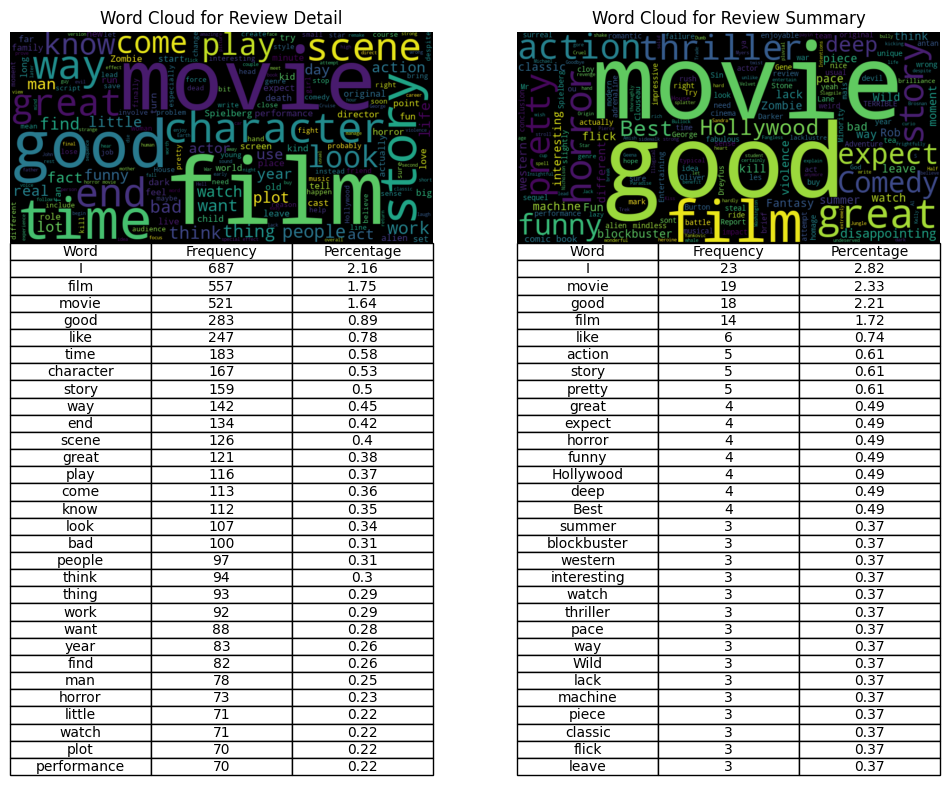

In [277]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Generate word clouds for review details and summary
wordcloud_detail = WordCloud(width=800, height=400).generate(' '.join(movie_reviews_df['cleaned_review_detail']))
wordcloud_summary = WordCloud(width=800, height=400).generate(' '.join(movie_reviews_df['cleaned_review_summary']))

# Plot word clouds
plt.figure(figsize=(12, 4))

# Subplot for word cloud of review detail
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_detail, interpolation='bilinear')
plt.title('Word Cloud for Review Detail')
plt.axis('off')  # Turning off the axis for it doesn't add value to the visualization we are aiming to show

# Subplot for word cloud of review summary
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.title('Word Cloud for Review Summary')
plt.axis('off')  # Turning off the axis for it doesn't add value to the visualization we are aiming to show

# Calculate word frequencies for review detail
words_detail = ' '.join(movie_reviews_df['cleaned_review_detail']).split()
word_freq_detail = Counter(words_detail)
total_words_detail = len(words_detail)
top_30_detail = [(word, freq, round(freq / total_words_detail * 100, 2)) for word, freq in word_freq_detail.most_common(30)]

# Calculate word frequencies for review summary
words_summary = ' '.join(movie_reviews_df['cleaned_review_summary']).split()
word_freq_summary = Counter(words_summary)
total_words_summary = len(words_summary)
top_30_summary = [(word, freq, round(freq / total_words_summary * 100, 2)) for word, freq in word_freq_summary.most_common(30)]

# Add tables for top 30 words with frequency and percentage below each subplot
plt.subplot(1, 2, 1)
table_data_detail = [['Word', 'Frequency', 'Percentage']] + top_30_detail
table = plt.table(cellText=table_data_detail, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.subplot(1, 2, 2)
table_data_summary = [['Word', 'Frequency', 'Percentage']] + top_30_summary
table = plt.table(cellText=table_data_summary, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()


__Visualization using PCA (Principal Component Analysis) to reduce the dimension of Bag of Words (Bow) representations using CountVectorizer on cleaned data on movie_reviews_df. Result is then plotted using Scatter Plots.

Top 1 Sentence:
movie contest small western town run gunslinger John Herod Gene Hackman Lady Sharon Stone Kid Leonardo DiCaprio retire gunslinger Cort Russel Crowe contestant greedy idiot John Herod surprisingly sign tournament movie entertain fast pace acting write decent idea small town great idea fresh original I enjoy movie amazingly overall exciting movie fun movie I recommend movie
PCA Vector: [-4.74508805  1.96602548]


Top 2 Sentence:
love Diane Lane actress year old mature simply fine actressess Hollywood movie sexy gorgeous talented funny possibly movie perfect summer date movie romantic comedy sex language wonderful enjoyable movie John Cusak usual fantastic actor genre movie equal task funny sad simply wonderful talented actor fit situation support cast great Stockard Channing Elizabeth Perkins Christopher Plummer play major fun role movie Durmet Mulrooney great miss
PCA Vector: [-4.44264058  1.96174509]


Top 3 Sentence:
movie stir polemical opinion certainly love hate opi

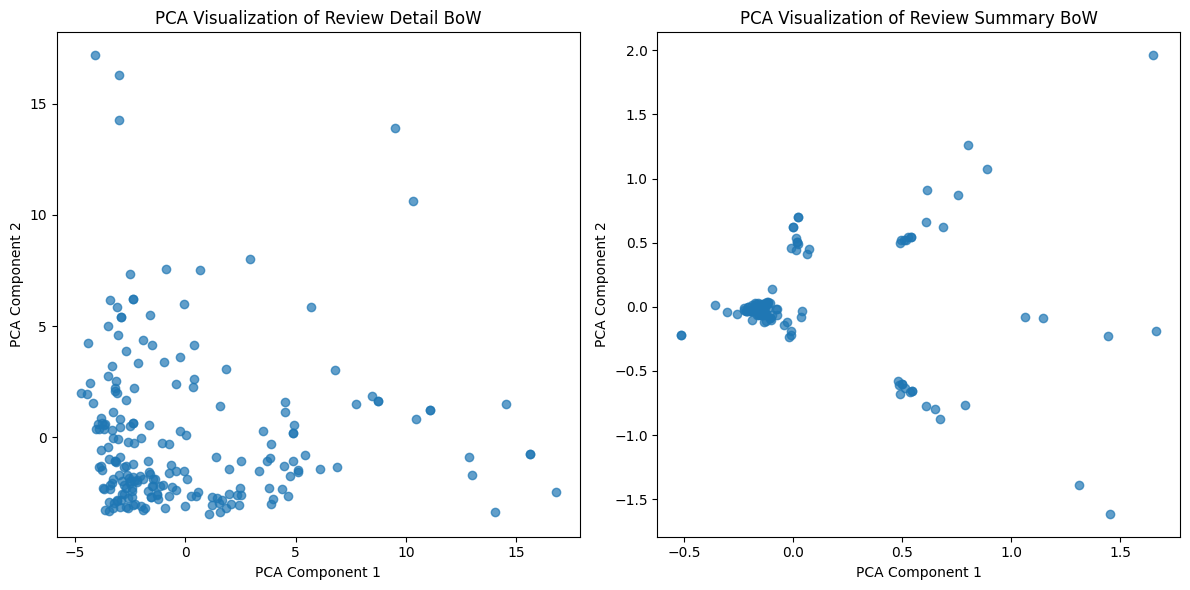

In [278]:
from textblob import TextBlob

# Add a 'sentiment' column to your DataFrame
movie_reviews_df['sentiment'] = movie_reviews_df['cleaned_review_detail'].apply(lambda x: TextBlob(x).sentiment.polarity)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create a CountVectorizer to convert text into a BoW representation
vectorizer = CountVectorizer()

# Fit and transform the review_detail and review_summary columns
review_detail_bow = vectorizer.fit_transform(movie_reviews_df['cleaned_review_detail'])
review_summary_bow = vectorizer.fit_transform(movie_reviews_df['cleaned_review_summary'])

# Perform PCA on the BoW representations
pca = PCA(n_components=2)
review_detail_pca = pca.fit_transform(review_detail_bow.toarray())
review_summary_pca = pca.fit_transform(review_summary_bow.toarray())

# Sort the review_detail and review_summary_pca sentences by the first PCA component (component 0)
sorted_indices_review_detail = review_detail_pca[:, 0].argsort()
sorted_indices_review_summary = review_summary_pca[:, 0].argsort()

# Get the top 5 sentences for review_detail and their corresponding PCA vectors
top_5_sentences_review_detail = [movie_reviews_df['cleaned_review_detail'].iloc[i] for i in sorted_indices_review_detail[:5]]
top_5_pca_vectors_review_detail = review_detail_pca[sorted_indices_review_detail[:5]]

# Print the top 5 sentences and their PCA vectors
for i, (sentence, pca_vector) in enumerate(zip(top_5_sentences_review_detail, top_5_pca_vectors_review_detail), 1):
    print(f"Top {i} Sentence:")
    print(sentence)
    print("PCA Vector:", pca_vector)
    print("\n")

# Get the top 5 sentences for review_summary and their corresponding PCA vectors
top_5_sentences_review_summary = [movie_reviews_df['cleaned_review_summary'].iloc[i] for i in sorted_indices_review_summary[:5]]
top_5_pca_vectors_review_summary = review_summary_pca[sorted_indices_review_summary[:5]]

# Print the top 5 sentences and their PCA vectors
for i, (sentence, pca_vector) in enumerate(zip(top_5_sentences_review_summary, top_5_pca_vectors_review_summary), 1):
    print(f"Top {i} Sentence:")
    print(sentence)
    print("PCA Vector:", pca_vector)
    print("\n")


# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(review_detail_pca[:, 0], review_detail_pca[:, 1], alpha=0.7)
plt.title('PCA Visualization of Review Detail BoW')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(review_summary_pca[:, 0], review_summary_pca[:, 1], alpha=0.7)
plt.title('PCA Visualization of Review Summary BoW')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

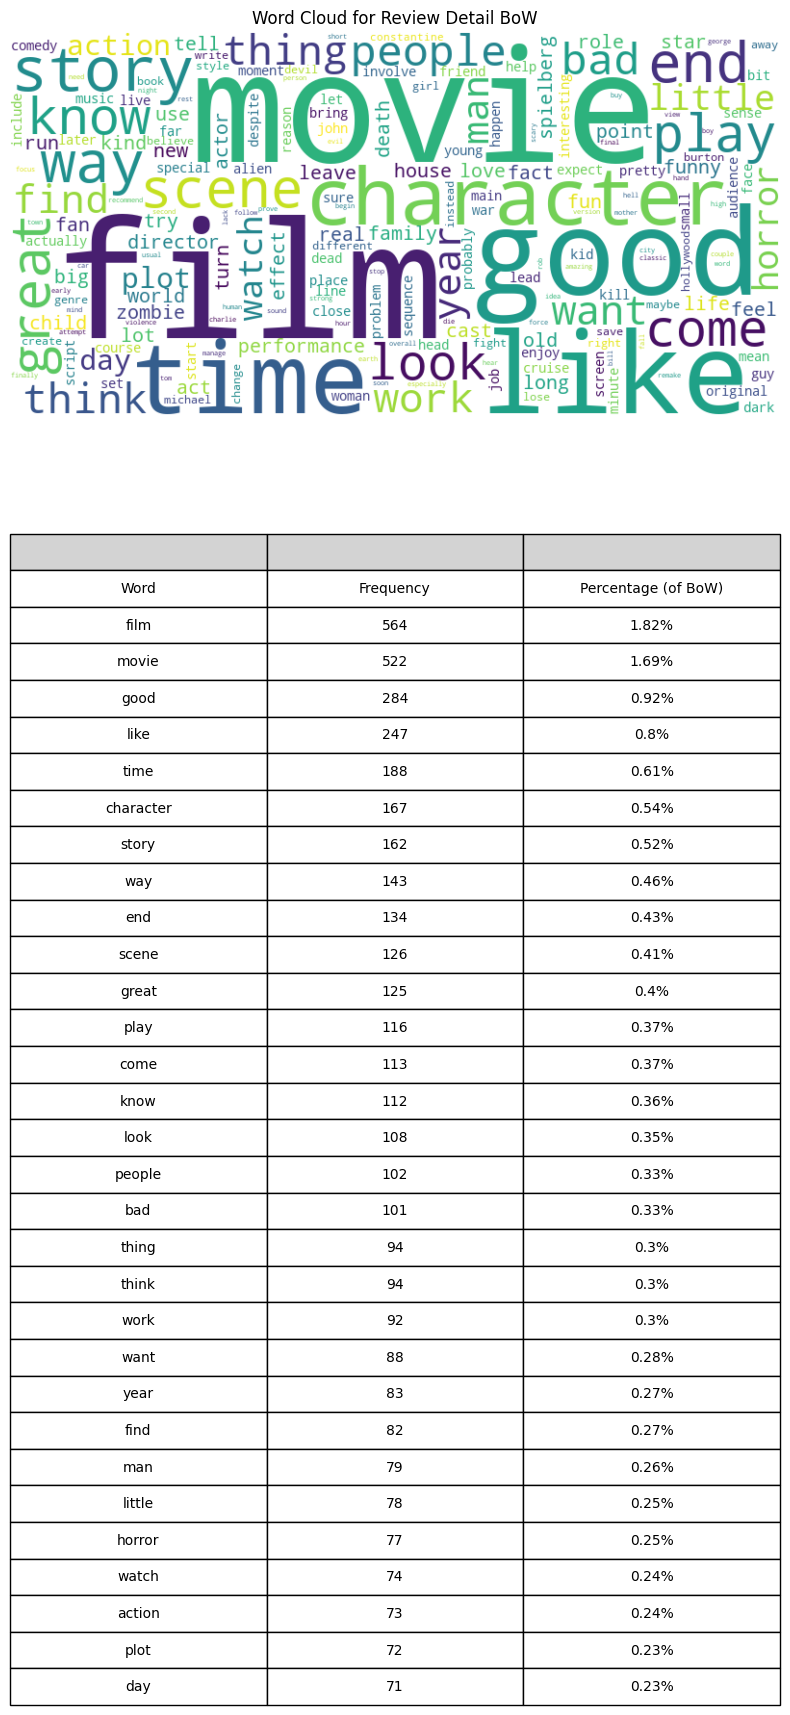

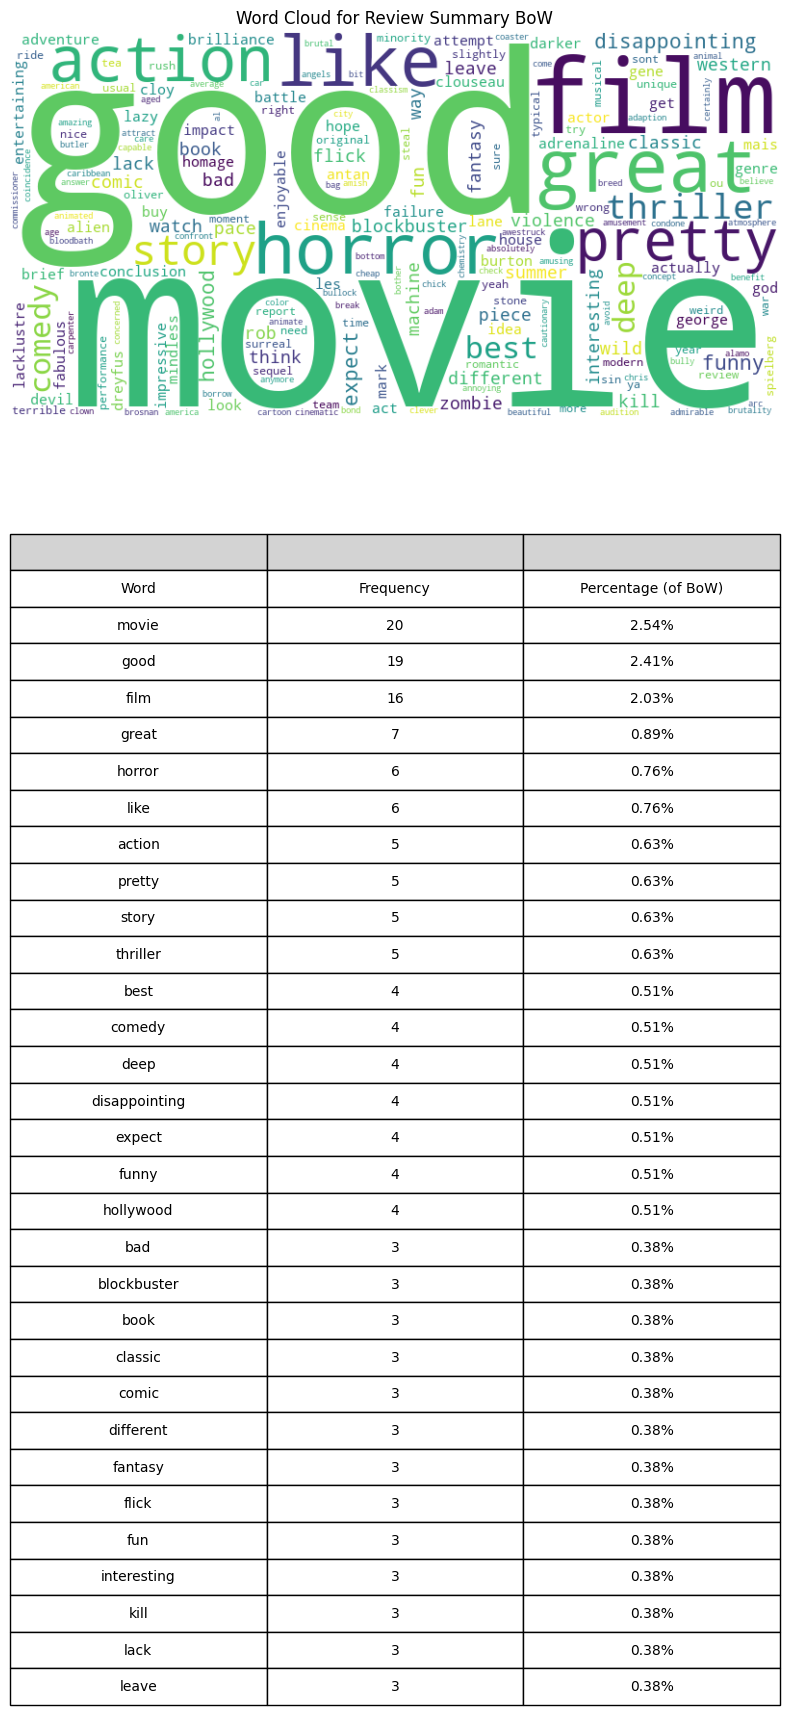

In [286]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Helper function to generate word cloud from BoW and display top 10 words with count and BoW percentage in a table
def generate_wordcloud_with_table(bow_matrix, title):
    feature_names = vectorizer.get_feature_names_out()
    word_freq = dict(zip(feature_names, bow_matrix.sum(axis=0).tolist()[0]))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Get total words in BoW
    total_words_bow = sum(word_freq.values())
    
    # Get top 30 words with counts and calculate their percentages based on BoW
    top_30_words = Counter(word_freq).most_common(30)
    table_data = [['Word', 'Frequency', 'Percentage (of BoW)']]
    
    for word, freq in top_30_words:
        bow_percentage = round((freq / total_words_bow) * 100, 2)
        table_data.append([word, freq, f"{bow_percentage}%"])

    # Display word cloud and table showing top 30 words, their frequency, and BoW percentages
    plt.figure(figsize=(8, 20))
    
    plt.subplot(2, 1, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    
    plt.subplot(2, 1, 2)
    table = plt.table(cellText=table_data, loc='center', cellLoc='center', colColours=['lightgray'] * 3)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate word cloud and display top 30 words with frequency and BoW percentage for review detail BoW
review_detail_bow = vectorizer.fit_transform(movie_reviews_df['cleaned_review_detail'])
generate_wordcloud_with_table(review_detail_bow, 'Word Cloud for Review Detail BoW')

# Generate word cloud and display top 30 words with frequency and BoW percentage for review summary BoW
review_summary_bow = vectorizer.fit_transform(movie_reviews_df['cleaned_review_summary'])
generate_wordcloud_with_table(review_summary_bow, 'Word Cloud for Review Summary BoW')


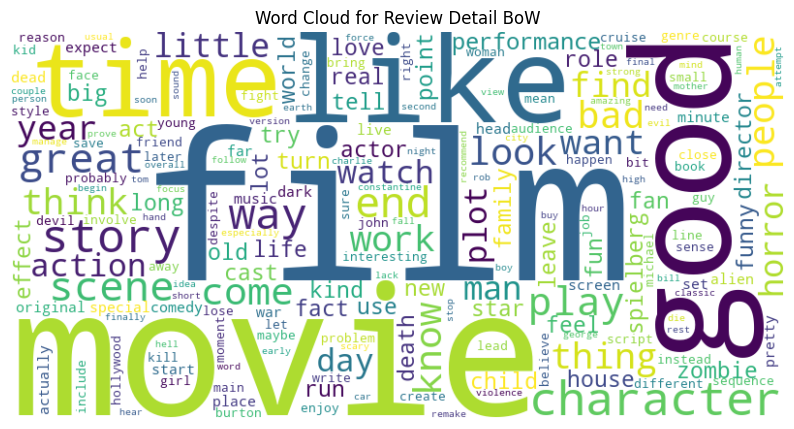

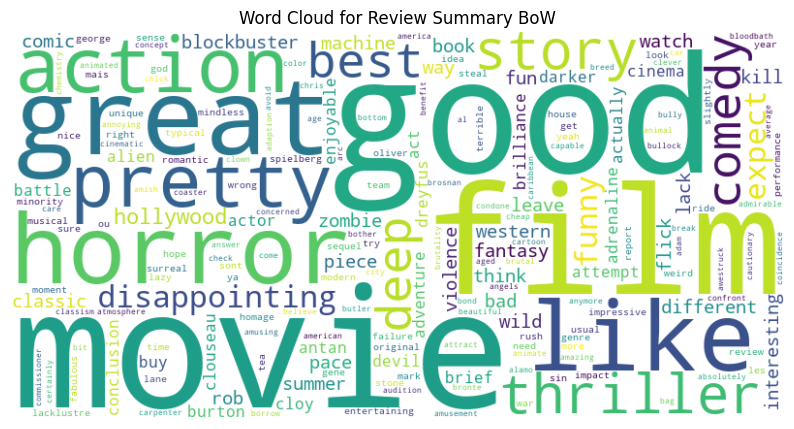

In [280]:
from wordcloud import WordCloud

# Helper function to generate word cloud from BoW
def generate_wordcloud(bow_matrix, title):
    feature_names = vectorizer.get_feature_names_out()
    word_freq = dict(zip(feature_names, bow_matrix.sum(axis=0).tolist()[0]))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for review detail BoW
review_detail_bow = vectorizer.fit_transform(movie_reviews_df['cleaned_review_detail'])
generate_wordcloud(review_detail_bow, 'Word Cloud for Review Detail BoW')

# Generate word cloud for review summary BoW
review_summary_bow = vectorizer.fit_transform(movie_reviews_df['cleaned_review_summary'])
generate_wordcloud(review_summary_bow, 'Word Cloud for Review Summary BoW')


In [281]:
# from gensim.models import Word2Vec
# import matplotlib.pyplot as plt

# # Tokenize the text data
# tokenized_text = movie_reviews_df['review_detail'].apply(lambda x: x.split())

# # Train a Word2Vec model
# model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)  # Adjust parameters as needed

# # Get word vectors
# word_vectors = model.wv

# # Visualize similar words using t-SNE
# from sklearn.manifold import TSNE

# # Reduce dimensionality with t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# word_vectors_2d = tsne.fit_transform(word_vectors.vectors)

# # Visualize the results
# plt.figure(figsize=(12, 8))
# plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.7)

# # Add labels to some words for illustration (Research further on better approach without manually declaring the words)
# words_to_label = ['good', 'bad', 'plot', 'acting', 'story', 'character', 'great', 'amazing', 'ugly', 'beautiful']
# for word in words_to_label:
#     idx = word_vectors.key_to_index.get(word)
#     if idx is not None:
#         plt.annotate(word, (word_vectors_2d[idx, 0], word_vectors_2d[idx, 1]))

# plt.title('t-SNE Visualization of Word2Vec Word Embeddings')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# #plt.show()

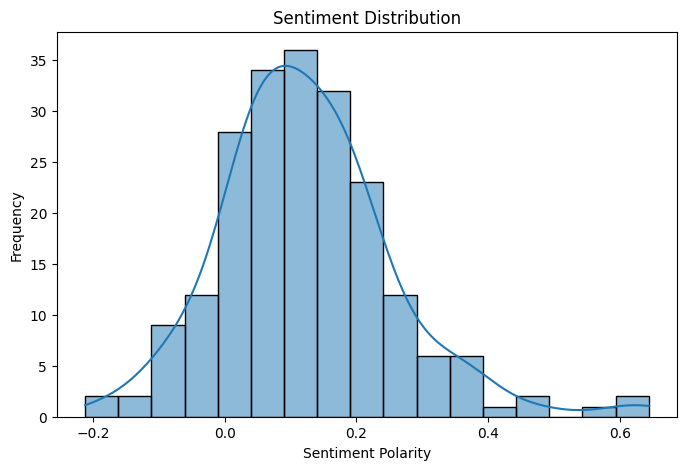

In [282]:
from textblob import TextBlob

# Sentiment analysis using TextBlob
movie_reviews_df['sentiment'] = movie_reviews_df['review_detail'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sns.histplot(movie_reviews_df['sentiment'], kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

## Model Creation

## Model Evaluation

## References
- https://medium.com/analytics-vidhya/text-preprocessing-nlp-basics-430d54016048
- https://towardsdatascience.com/how-to-preprocess-social-media-data-and-text-messages-b011efacf74
- https://towardsdatascience.com/5-lesser-known-python-libraries-for-your-next-nlp-project-ff13fc652553
- https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff
- https://sunscrapers.com/blog/9-best-python-natural-language-processing-nlp/
- https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#google_vignette
- https://atilaycemsamiloglu.medium.com/what-is-lemmatization-2d7a87f42c55
- https://support.prodi.gy/t/how-to-tell-spacy-not-to-split-any-intra-hyphen-words/1456
- https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8
- https://python.plainenglish.io/optimize-your-spacy-ner-results-with-this-simple-change-e59937c411ab